# Recurrent Neural Net w/Embedding w/TimeWave
---
In real life fraud detection, the notion of time is very important. It tends to make a real difference if 2 events happen within 3 seconds or 3 months of eachother

A potential flaw with the stacked series is that we just stack the latest transactions, but it's totally not clear how far apart (in time) each of the transaction in the series are. 

Broadly speaking it's not a good idea to just provide exact date/time to a model, it tends to be fairly precise/identifiable data and can make a model overfit really easily. It might just learn about the exact dates/times at which fraud occur. Breaking the time up into months, days, hours etc... can sometimes lead to the same overfitting.

In this model we will try an experiment based on the positional encoding idea of `transformers`. At this point in time it's not essential to understand transformers. But -some- have this interesting concept of `positional encoding` to help the model understand the exact position of words. In those encodings, the positions are turned into **sine and cosine** waves of various frequencies. We will encode the time into sine/cosine waves, not the positions. These waves will -hopefully- help the model understand how far appart the individual entries in the series are.

As a general caveat, note that in this data, there is no seconds or hours, it's unclear if the time sequence holds realistice patterns and the timing on the merchant key is probably less important than on the card key. It's likely safe to assume the influx into a merchant is much more constant than the outgoing traffic on a card.

As such this model maybe more illustrative than powerful.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import gc
import datetime as dt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../../data/bs140513_032310.csv'

## Define Features

### Define Base Features

In [5]:
# Base Features
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

td_base = ft.TensorDefinition('all', [step, customer, age, gender, merchant, category, amount, fraud])

## Visualise the Waves

In order to get a feel for what we are encoding let's visualise the waves. Below snippet of code will create a `FeatureDateTimeWave` with following attributes.
- The **date_time** as base feature. This needs to obviously have a DateTimeFormat.
- The date_time is formatted with format code **%j**, which turns it into a 'day of year' between 1 and 366.
- The **period** is set to 366/2. This data spans about half a year, so this way we get one full '360' of the base wave per 1/2 year.
- The **frequencies** is set to 2. This will give use 2 frequencies. Each one has exactly double the frequency of the previous wave.

In [6]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

waves = ft.FeatureDateTimeWave('time_waves', ft.FEATURE_TYPE_FLOAT_32, date_time, '%j', int(366/2), 2)

td_series_wv   = ft.TensorDefinition('stacked_wave', [date_time, waves])

with en.EnginePandas(num_threads=1) as e:
    df = e.df_from_csv(td_series_wv, file, time_feature=date_time, inference=False)

2023-07-01 16:28:00.244 eng1n3.common.engine           INFO     Start Engine...
2023-07-01 16:28:00.245 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-07-01 16:28:00.246 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-07-01 16:28:00.252 eng1n3.pandas.pandasengine     INFO     Building Panda for : stacked_wave from file ../../../../../data/bs140513_032310.csv
2023-07-01 16:28:04.795 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: stacked_wave


In [7]:
df

,date,time_waves__sin__0,time_waves__cos__0,time_waves__sin__1,time_waves__cos__1
0,2020-01-01,0.034328,0.999411,0.068615,0.997643
1,2020-01-01,0.034328,0.999411,0.068615,0.997643
2,2020-01-01,0.034328,0.999411,0.068615,0.997643
3,2020-01-01,0.034328,0.999411,0.068615,0.997643
4,2020-01-01,0.034328,0.999411,0.068615,0.997643
...,...,...,...,...,...
594638,2020-06-28,-0.102821,0.994700,-0.204552,0.978856
594639,2020-06-28,-0.102821,0.994700,-0.204552,0.978856
594640,2020-06-28,-0.102821,0.994700,-0.204552,0.978856
594641,2020-06-28,-0.102821,0.994700,-0.204552,0.978856


If we look at the unique dates, then we see we created.
- time_waves__sin__0: A base sine wave on a 1/2 year period.
- time_waves__cos__0: A base cosine wave on a 1/2 year period.
- time_waves__sin__1: A sine wave with double the frequency as the base sine wave.
- time_waves__cos__1: A cosing wave with double the frequency as the base cosine wave.

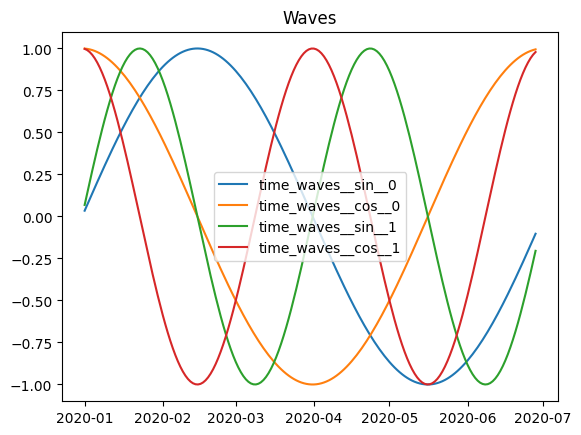

In [9]:
# Group per date and get first entry (wave).
wav = df.groupby('date').first().reset_index()
# Plot
for d in [d for d in df.columns if d.startswith('time_waves__')]: 
    plt.plot(wav['date'], wav[d], label=d)
plt.title('Waves')
plt.legend()
plt.show()

### Define Derived Features
For this example we have included a series base on a `FeatureDateTimeWave`.

It is set-up as a separate series because it has a Float type and we are going to consider it as a `continuous` learning type feature, we are not going to be running them through embeddings.


In [10]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

# Categorical Features
amount_bin   = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
age_i        = ft.FeatureIndex('age_i', ft.FEATURE_TYPE_INT_8, age)
gender_i     = ft.FeatureIndex('gender_i', ft.FEATURE_TYPE_INT_8, gender)
merchant_i   = ft.FeatureIndex('merchant_i', ft.FEATURE_TYPE_INT_8, merchant)
category_i   = ft.FeatureIndex('category_i', ft.FEATURE_TYPE_INT_8, category)

# TimeWaves
waves       = ft.FeatureDateTimeWave('time_waves', ft.FEATURE_TYPE_FLOAT_32, date_time, '%j', int(366/2), 2)

# Label Feature
fraud_label  = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

stacked_ref_series = ft.FeatureSeriesStacked(
    'stacked_ref', ft.FEATURE_TYPE_INT_8, [amount_bin, age_i, gender_i], 5, merchant
)

# TensorDefinition for the stacked wave
stacked_wave_series = ft.FeatureSeriesStacked(
    'stacked_wave', ft.FEATURE_TYPE_FLOAT_32, [waves], 5, merchant
)

td_series_ref  = ft.TensorDefinition('stacked_ref', [stacked_ref_series])
td_series_wv   = ft.TensorDefinition('stacked_wave', [stacked_wave_series])
td_referential = ft.TensorDefinition('referential', [merchant_i, category_i])
td_label       = ft.TensorDefinition('label', [fraud_label])

with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_series_ref, td_series_wv, td_referential, td_label), file, time_feature=date_time, inference=False)

2023-07-01 16:29:01.982 eng1n3.common.engine           INFO     Start Engine...
2023-07-01 16:29:01.983 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-07-01 16:29:01.983 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-07-01 16:29:01.983 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../../data/bs140513_032310.csv
2023-07-01 16:29:06.644 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-07-01 16:29:06.660 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked_ref using 1 process(es)
2023-07-01 16:29:06.772 e...ureseriesstackedprocessor  INFO     Returning series of type int8.
2023-07-01 16:29:06.773 e...ureseriesstackedprocessor  INFO     Series Shape=[(-1, 5, 3)]
2023-07-01 16:29:06.773 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked_wave using 1 process(es)
2023-07-01 16

In [11]:
ti

TensorInstance with shapes: ((594643, 5, 3), (594643, 5, 4), (594643, 2), (594643, 1))

In [12]:
ti.dtype_names

('int8', 'float32', 'int8', 'int8')

## Create Data-Sets and Loaders

In [13]:
train, val, test = ti.split_sequential(30000, 100000)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((464643, 5, 3), (464643, 5, 4), (464643, 2), (464643, 1))
((30000, 5, 3), (30000, 5, 4), (30000, 2), (30000, 1))
((100000, 5, 3), (100000, 5, 4), (100000, 2), (100000, 1))


## Create LSTM Model
In order to process this data we will need a sort of 3-headed monster model. It will have the same heads at the previous model, i.e. one for the indexes in the timeseries and one for the indexes of the merchant referential data. 

Besides those it will have another head for the time-waves. The waves are floating point numbers and have a continuous learning type, they are not run through an embedding. 

The logic of this model is to process the payment series data through an embedding, concatenate the wave series to the the output of the embedding (they have the same length). Then process the concatented embedding/wave series through an LSTM, take the last output, concatenate the output of the merchant embedding to it and feed to the linear layers. (The picture probably makes this clearer)

In [14]:
class BankSimLSTM(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(BankSimLSTM, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        
        lstm_size = 8 
        # The first head is the Series. Create an LSTM to process it. Use Batch first to get a BxSxF output!
        self.lstm = nn.LSTM(self.heads[0].output_size+self.heads[1].output_size, lstm_size, batch_first=True)
        
        # Set of layers
        self.layers = mp.LinLayer(
            input_size=self.heads[2].output_size+lstm_size, layer_sizes=((16,8)), dropout=0.0, bn_interval=2
        )       

        # And a tail layer. For a binary classifier this adds a linear layer to output a size of 1 + Sigmoid
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # Run heads logic
        h0 = self.heads[0](x[0])
        h1 = self.heads[1](x[1])
        h2 = self.heads[2](x[2])
        # Pass head 0 and 1 (the series) through the LSTM. Concatenate them first.
        h_l = torch.cat((h0, h1), dim=2)
        o, _ = self.lstm(h_l)
        # Take the final output
        o = o[:, -1, :]
        # Concatenate to head 2.
        o = torch.cat((h2, o), dim=1)
        # Run through linear layers.
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a model instance
model = BankSimLSTM(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

BankSimLSTM(
  Number of parameters : 4004. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=SeriesTD, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(9, 5)
          (2): Embedding(5, 5)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(Name=SeriesTD, lc=Continuous)
    (2): TensorDefinitionHead(
      Name=referential, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(51, 25)
          (1): Embedding(16, 8)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (lstm): LSTM(29, 8, batch_first=True)
  (layers): LinLayer(
    (layers): Sequential(
      (lin_layer_01): Linear(in_features=41, out_features=16, bias=True)
      (lin_act_01): ReLU()
      (lin_layer_02): Linear(in_features=16, out_features=8, bias=True)
     

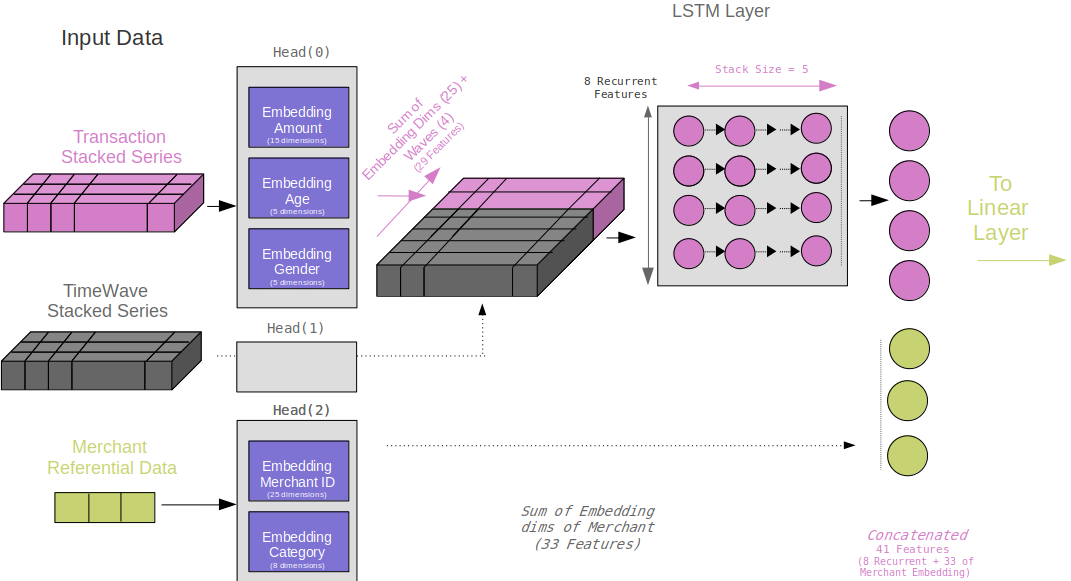

## Train

Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 214.59it/s]                                                    


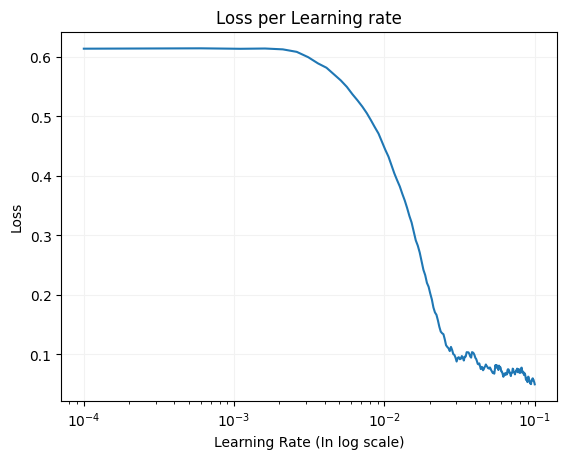

In [15]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = BankSimLSTM(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);
del m_lr, o_lr, t_lr, lrs
_ = gc.collect()

In [16]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=8e-3)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCH] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3866/3866 [00:08<00:00, 477.20it/s, t_loss=0.032, t_acc=0.991, v_loss=0.0347, v_acc=0.987]     


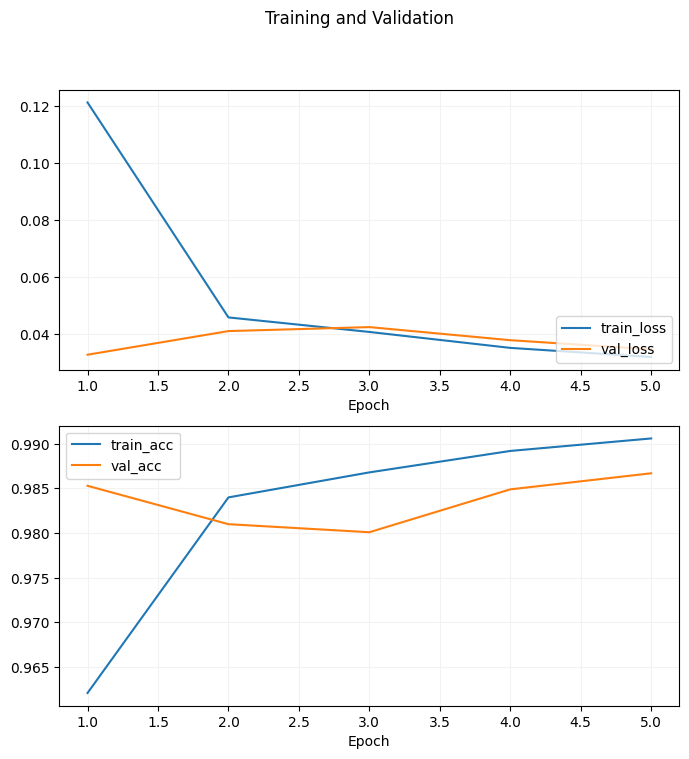

In [17]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

Testing in 782 steps: 100%|█████████████████| 782/782 [00:00<00:00, 1007.74it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     98926
         1.0       0.53      0.96      0.68      1074

    accuracy                           0.99    100000
   macro avg       0.76      0.97      0.84    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9987
ap score  : 0.9216
-----------------------------------------------------


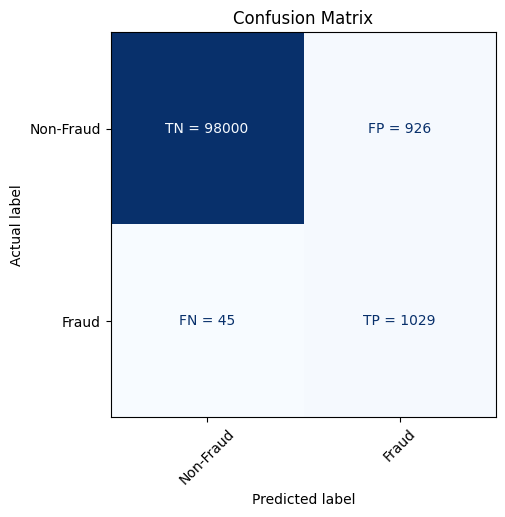

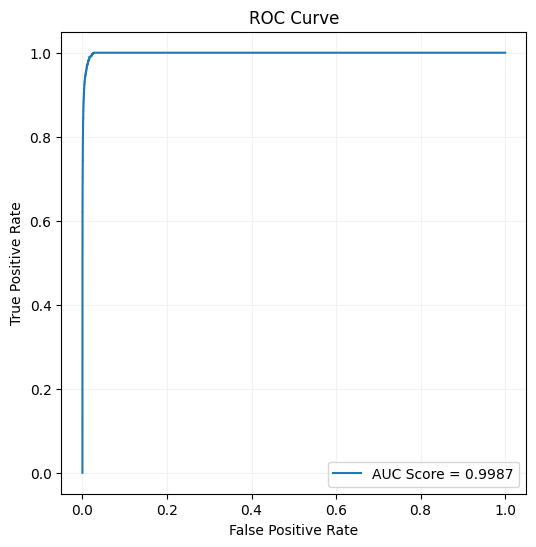

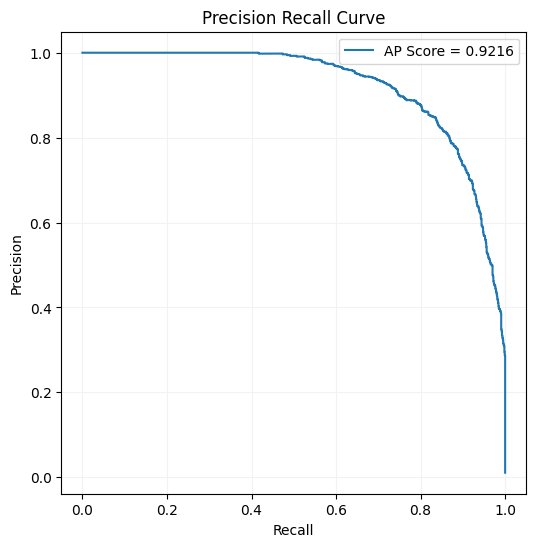

In [18]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5));
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

# Conclusion

Adding the time as sin/cosine wave did not help the model, on the contrary, it was less powerful than the previous model. There is the possibility that we are 'washing out' the sequence information, we only have 8 recurrent feaures, so really we could have tried with more Recurrent Features. But not knowing if the 'time'-data makes sense, the model has not been tuned.

It's probably save to assume though that on real data and especially if the series is key'ed by card/customer, the date-time wave will most likely prove to help.